In [5]:
import numpy as np
import matplotlib.pyplot as plt
from calcwf import gen_wf, shifted_f, shifted_e, match_wfs, get_h

In [2]:
# Global settings
sample_rate = 4096

# Shifted frequency plots

In [28]:
# Calculates match over range of intial frequency values
def s_f_quad_match(fiducials, e_Ms, s_f_len, f_low, approximant, approx_sinusoidal=False, subsample_interpolation=True):

    # Generate fiducial waveform
    fid_wf = gen_wf(f_low, *fiducials, sample_rate, approximant)

    # Intialise plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    if len(e_Ms) == 1:
        ax2 = ax1.twiny()
    
    gridsize = len(e_Ms)*s_f_len
    progress = 0
    for i, e_M in enumerate(e_Ms):
        e, M = e_M
        
        # Creates grid dimension of shifted frequency
        max_s_f = shifted_f(f_low, e, M, fiducials[2])
        s_f_vals = np.linspace(f_low, max_s_f, s_f_len, endpoint=True)
        s_e_vals = shifted_e(s_f_vals, f_low, e)
        s_f_matches_1 = []
        s_f_matches_2 = []
    
        # Loops over each initial frequency
        for s_f, s_e in zip(s_f_vals, s_e_vals):
    
            # Create waveform to match
            h, h1, h2, h_ap, h_peri = get_h([1,1], s_f, s_e, M, fiducials[2], sample_rate, 
                                             approximant=approximant, subsample_interpolation=subsample_interpolation)

            # Matches against h1
            match = match_wfs(fid_wf, h1, s_f, subsample_interpolation=subsample_interpolation)
            s_f_matches_1.append(match)
            # Matches against h2
            match = match_wfs(fid_wf, h2, s_f, subsample_interpolation=subsample_interpolation)
            s_f_matches_2.append(match)
        
            # Progress bar
            progress += 1
            if progress%10 == 0 or progress == gridsize:
                print('\r' + f'{progress} done out of {gridsize}', end='')
    
        # Makes plot
        s_f_matches_quad = np.sqrt(np.array(s_f_matches_1)**2+np.array(s_f_matches_2)**2)
        ax1.plot(s_f_vals, s_f_matches_1, ls='dashed', c=f'C{i}', label=f'h1 $e={e}$, $M={M}~M_\odot$')
        ax1.plot(s_f_vals, s_f_matches_2, ls='dotted', c=f'C{i}', label=f'h2 $e={e}$, $M={M}~M_\odot$')
        ax1.plot(s_f_vals, s_f_matches_quad, ls='solid', c=f'C{i}', label=f'quad $e={e}$, $M={M}~M_\odot$')
        ax1.set_xlabel('Shifted frequency')
        if len(e_Ms) == 1:
            ax2.plot(s_e_vals, s_f_matches_1, alpha=0)
            ax2.invert_xaxis()
            ax2.set_xlabel('Shifted eccentricity')

    # Finish plot
    ax1.legend()
    ax1.set_ylabel('Match')
    ax1.set_title(f'Fiducial waveform of $e={fiducials[0]}$ at $f={f_low}~Hz$, $M={fiducials[1]}~M_\odot$')

    return fid_wf

51 done out of 51

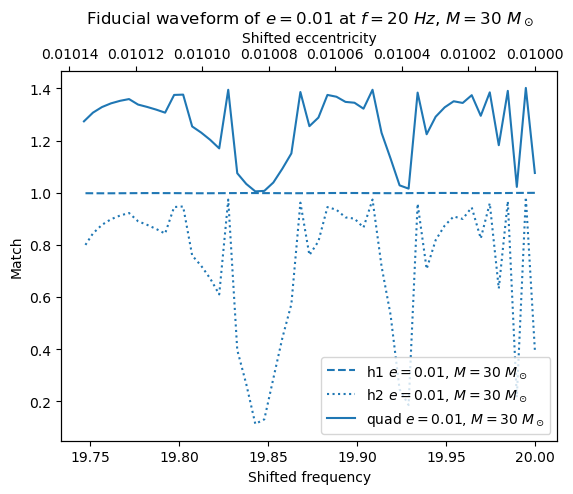

In [31]:
fid_wf = s_f_quad_match([0.01, 30, 2], [(0.01, 30)], 51, 20, 'EccentricTD')

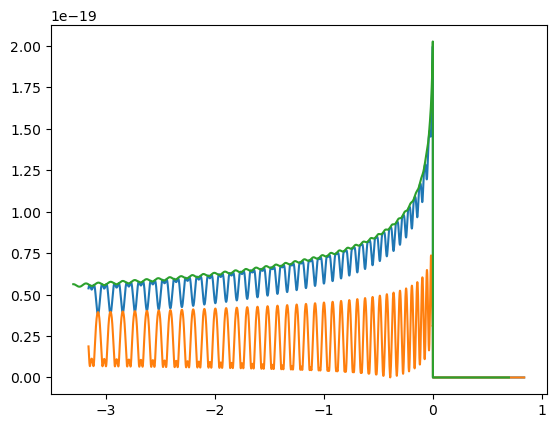

In [33]:
plt.plot(h1.sample_times, np.sqrt(h1.real()**2+h1.imag()**2))
plt.plot(h2.sample_times, np.sqrt(h2.real()**2+h2.imag()**2))
plt.plot(fid_wf.sample_times, np.sqrt(fid_wf.real()**2+fid_wf.imag()**2))